In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
data_transforms = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                          std = [0.229, 0.224, 0.225])
                                     ])

dataset = ImageFolder(root = "./Dataset", transform=data_transforms)


In [4]:

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

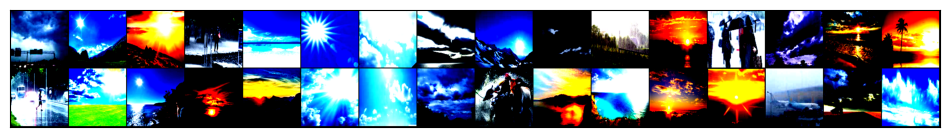

In [60]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(tl):
  for images, lables in tl:
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
    break

show_batch(train_loader)


In [61]:
import torch.nn as nn
import torch.nn.functional as F
from model import WeatherCNN

class EarlyStopper:
    def __init__(self, patience = 1, min_delta = 0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
      
    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
              return True
        return False


model = WeatherCNN().to(device)
early_stopper = EarlyStopper(patience = 3, min_delta = 0.1)


In [62]:

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)


num_epochs = 100
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad() # setting gradients as zero
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)

    # ------------------------------------------------------ #
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct/total:.2f}%')

    if early_stopper.early_stop(avg_val_loss):
      print("Model is Overfitting from :-" + str(epoch) + " epoch")
      break



torch.save(model.state_dict(), "trained_model.pth")
print("MODEL SAVED AS 'trained_model.pth'")


Epoch [1/10], Loss: 1.3068
Validation Loss: 0.4063, Accuracy: 87.56%
Epoch [2/10], Loss: 0.4139
Validation Loss: 0.3210, Accuracy: 89.78%
Epoch [3/10], Loss: 0.2877
Validation Loss: 0.3896, Accuracy: 89.33%
Epoch [4/10], Loss: 0.2774
Validation Loss: 0.2829, Accuracy: 89.78%
Epoch [5/10], Loss: 0.1520
Validation Loss: 0.6706, Accuracy: 88.44%
Epoch [6/10], Loss: 0.1167
Validation Loss: 0.2757, Accuracy: 91.56%
Epoch [7/10], Loss: 0.0641
Validation Loss: 0.3251, Accuracy: 92.89%
Epoch [8/10], Loss: 0.0471
Validation Loss: 0.3251, Accuracy: 92.44%
Epoch [9/10], Loss: 0.0592
Validation Loss: 0.4002, Accuracy: 85.78%
Epoch [10/10], Loss: 0.2411
Validation Loss: 0.3413, Accuracy: 90.67%
MODEL SAVED AS 'trained_model.pth'


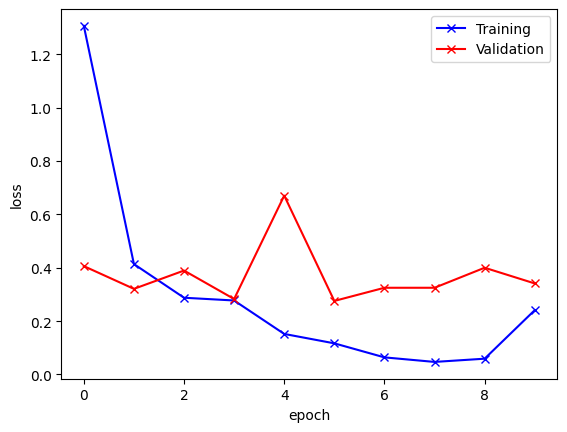

In [63]:
plt.plot(train_loss_list, '-bx')
plt.plot(val_loss_list, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])